Idea: When B stabilizes, the topics will be stable and hence G will be comparable.

We perform many iterations and verify B converges.

After B converges, we take the graphs from those iterations and choose the most frequent one.

In [1]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 100 # Amount of documents
V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 5 

k = 6 # Amount of topics
gamma = 0.2

# FA: Since we're testing so much, lets agree on using just 1 small set of global variables for now

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [10]:
from simulator import Simulator
from samplers import MC_sample_Z, MC_sample_B, MC_sample_H, MC_sample_GK
from transformation_functions import update_Theta, update_Sigma, update_E, update_C
from generator_functions import sample_Z_from_W

# 4. MAIN CYCLE

### Generating Target Data

These data will be used as input (matrix Z and W) and target (matrix G) for our simulation. 

In [11]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1888)
simulated_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


In [12]:
# Input Data:
simulated_data.W

array([[2., 1., 3., ..., 5., 2., 0.],
       [3., 3., 2., ..., 2., 4., 2.],
       [1., 1., 1., ..., 2., 2., 0.],
       ...,
       [0., 2., 0., ..., 1., 0., 1.],
       [2., 2., 0., ..., 2., 1., 3.],
       [2., 1., 0., ..., 1., 2., 3.]])

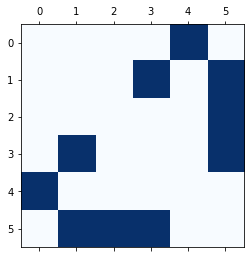

In [13]:
# Target graph
plt.matshow(simulated_data.G, cmap='Blues')

### Generating Initial Data

These are used as our initial guess for Sigma, K, B, Theta and G

In [14]:
# # Initial guesses
initial = Simulator(D, V, M, k, gamma, 2020)
initial.sample_GK()
initial.sample_B()
initial.sample_H()

Success: Sigma transformed from K
Success: G transformed from K


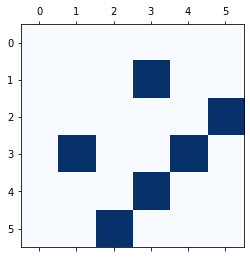

In [15]:
# Initial graph
plt.matshow(initial.G, cmap='Blues')

## Global Sampler

All objects are updated within the cycle.

In [ ]:
%%time
max_iterations = 4000
np.random.seed(25041945)

# Initialization
Sigma = initial.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial.B.copy()
Theta = initial.Theta.copy()
G = initial.G.copy()

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = sample_Z_from_W(simulated_data.W.astype(int), k, 2020)  # Random sample of Z based on actual data

E = update_E(np.zeros((D, k)), Z)  # Transformation of Z
C = update_C(np.zeros((k, V)), Z)  # Transformation of Z

H = None
step = 0.5

waiting_times = []
sampled_Gs = []
#edges_log = []
#errors_log = []
#graph_changes = []
B_converge = [] 

for iteration in range(max_iterations):
    
    # Step 1
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True) 
    
    # Step 2
    last_B = B.copy()
    B = MC_sample_B(alpha, C)
    B_converge.append(np.linalg.norm(B - last_B))
    
    # Step 3
    H, step = MC_sample_H(E, Sigma, K, step_size=step, H_current=H, burn_in=15)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    #if np.all(G_new == G_old):
    #    print('G matrix has NOT changed!')
    #graph_changes.append(~np.all(G_new == G_old))
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times.append(wt_sample)
    sampled_Gs.append(G.copy())
    
    # Hope for convergence!
    #wrong_edges = np.sum(G != simulated_data.G)
    #error = np.linalg.norm(Sigma - simulated_data.Sigma)
    #print(f"At iteration {iteration}, the wrong edges are {wrong_edges} and the error on Sigma is {error}. Waiting time {wt_sample}")
    
    #edges_log.append(wrong_edges)
    #errors_log.append(error)
    
    if iteration%1000==0:
        print('Now at iteration '+str(iteration)+'/'+str(max_iterations))
    #    plt.matshow(G, cmap='Blues')
    #    plt.suptitle("Graph of iteration "+str(iteration), x=0.5, y=1, ha='center')
    #    plt.show()

In [ ]:
B_converge = pd.Series(B_converge)

print("B convergence metrics")
print(B_converge.describe())

B_converge.hist(bins=30)  # Should look like an exponential decay?
plt.suptitle('B marginal changes histogram', x=0.5, y=1, ha='center')
plt.show()

B_converge.plot(title="B convergence series")  # Find where it stabilizes
# TODO: Add the finder for a certain threshold and plot the vertical line of the iteration and save variable
cut = 
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

In [ ]:
G_matrices = pd.Series(sampled_Gs[cut:])  # Should this work?

G_matrices.hist(bins=30)
plt.suptitle('Sampled graphs histogram', x=0.5, y=1, ha='center')
plt.show()

plt.matshow(G_matrices.mode(), cmap='Blues')
plt.suptitle("Most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

In [ ]:
wait_times = pd.Series(waiting_times)
wait_times.plot(title="Waiting times series")
plt.show()